### Import the required packages

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import matplotlib.patches as patches
import pandas
from keras.utils import np_utils

from keras import optimizers
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.layers import Activation
from keras.utils import to_categorical
from keras.layers import Conv2D, Flatten, MaxPooling2D, LocallyConnected2D


In [3]:
# On some implementations of matplotlib, you may need to change this value
IMAGE_SIZE = 72

In [4]:
def generate_a_drawing(figsize, U, V, noise=0.0):
    fig = plt.figure(figsize=(figsize,figsize))
    ax = plt.subplot(111)
    plt.axis('Off')
    ax.set_xlim(0,figsize)
    ax.set_ylim(0,figsize)
    ax.fill(U, V, "k")
    fig.canvas.draw()
    imdata = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)[::3].astype(np.float32)
    imdata = imdata + noise * np.random.random(imdata.size)
    plt.close(fig)
    return imdata

def generate_a_rectangle(noise=0.0, free_location=False):
    figsize = 1.0    
    U = np.zeros(4)
    V = np.zeros(4)
    if free_location:
        corners = np.random.random(4)
        top = max(corners[0], corners[1])
        bottom = min(corners[0], corners[1])
        left = min(corners[2], corners[3])
        right = max(corners[2], corners[3])
    else:
        side = (0.3 + 0.7 * np.random.random()) * figsize
        top = figsize/2 + side/2
        bottom = figsize/2 - side/2
        left = bottom
        right = top
    U[0] = U[1] = top
    U[2] = U[3] = bottom
    V[0] = V[3] = left
    V[1] = V[2] = right
    return generate_a_drawing(figsize, U, V, noise)


def generate_a_disk(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        center = np.random.random(2)
    else:
        center = (figsize/2, figsize/2)
    radius = (0.3 + 0.7 * np.random.random()) * figsize/2
    N = 50
    U = np.zeros(N)
    V = np.zeros(N)
    i = 0
    for t in np.linspace(0, 2*np.pi, N):
        U[i] = center[0] + np.cos(t) * radius
        V[i] = center[1] + np.sin(t) * radius
        i = i + 1
    return generate_a_drawing(figsize, U, V, noise)

def generate_a_triangle(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        U = np.random.random(3)
        V = np.random.random(3)
    else:
        size = (0.3 + 0.7 * np.random.random())*figsize/2
        middle = figsize/2
        U = (middle, middle+size, middle-size)
        V = (middle+size, middle-size, middle-size)
    imdata = generate_a_drawing(figsize, U, V, noise)
    return [imdata, [U[0], V[0], U[1], V[1], U[2], V[2]]]


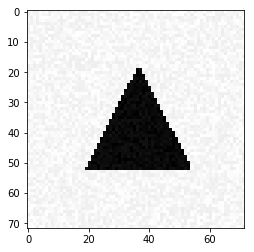

In [5]:
im = generate_a_rectangle(10, True)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

im = generate_a_disk(10)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

[im, v] = generate_a_triangle(20, False)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')


In [6]:
def generate_dataset_classification(nb_samples, noise=0.0, free_location=False):
    # Getting im_size:
    im_size = generate_a_rectangle().shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros(nb_samples)
    print('Creating data:')
    for i in range(nb_samples):
        if i % 10 == 0:
            print(i)
        category = np.random.randint(3)
        if category == 0:
            X[i] = generate_a_rectangle(noise, free_location)
        elif category == 1: 
            X[i] = generate_a_disk(noise, free_location)
        else:
            [X[i], V] = generate_a_triangle(noise, free_location)
        Y[i] = category
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]

def generate_test_set_classification():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_classification(300, 20, True)
    Y_test = np_utils.to_categorical(Y_test, 3) 
    return [X_test, Y_test]

def generate_dataset_regression(nb_samples, noise=0.0):
    # Getting im_size:
    im_size = generate_a_triangle()[0].shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros([nb_samples, 6])
    print('Creating data:')
    for i in range(nb_samples):
        if i % 10 == 0:
            print(i)
        [X[i], Y[i]] = generate_a_triangle(noise, True)
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]


In [7]:
def visualize_prediction(x, y):
    fig, ax = plt.subplots(figsize=(5, 5))
    I = x.reshape((IMAGE_SIZE,IMAGE_SIZE))
    ax.imshow(I, extent=[-0.15,1.15,-0.15,1.15],cmap='gray')
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])

    xy = y.reshape(3,2)
    tri = patches.Polygon(xy, closed=True, fill = False, edgecolor = 'r', linewidth = 5, alpha = 0.5)
    ax.add_patch(tri)

    plt.show()

def generate_test_set_regression():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_regression(300, 20)
    return [X_test, Y_test]



# 3. Simple Classification

In [8]:
# Let us now generate a random set of images
[X_train, Y_train] = generate_dataset_classification(300, 20)

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


In [10]:
# Let us now convert the target variables as 3 separate categories
Y_train = to_categorical(Y_train, 3)

In [11]:
Y_train.shape

(300, 3)

## Stochastic Gradient Descent Optimizer

In [19]:
# Initiate the number of neurons to be used
neurons = 128

In [20]:
# pass optimizer by name of SGD: default parameters will be used 
model_sgd = Sequential()
model_sgd.add(Dense(neurons, activation='relu'))
model_sgd.add(Dense(neurons, activation='relu'))
model_sgd.add(Dense(neurons, activation='relu'))
model_sgd.add(Dense(3, activation='softmax'))

# Initiate the SGD optimizer with the required set of parameters
sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)

In [21]:
# Now we will compile the model with the metrics of measure and the optimizer to be used for it to be trained with
model_sgd.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['acc'])

In [22]:
model_sgd.fit(X_train, Y_train, epochs=20)

Epoch 1/20
300/300 [==============================] - 0s 2ms/step - loss: 0.2208 - acc: 0.4833
Epoch 2/20
300/300 [==============================] - 0s 549us/step - loss: 0.1916 - acc: 0.6367
Epoch 3/20
300/300 [==============================] - 0s 532us/step - loss: 0.1833 - acc: 0.6133
Epoch 4/20
300/300 [==============================] - 0s 545us/step - loss: 0.1712 - acc: 0.6400
Epoch 5/20
300/300 [==============================] - 0s 525us/step - loss: 0.1638 - acc: 0.7233
Epoch 6/20
300/300 [==============================] - 0s 506us/step - loss: 0.1539 - acc: 0.6867
Epoch 7/20
300/300 [==============================] - 0s 492us/step - loss: 0.1463 - acc: 0.7433
Epoch 8/20
300/300 [==============================] - 0s 502us/step - loss: 0.1452 - acc: 0.7200
Epoch 9/20
300/300 [==============================] - 0s 511us/step - loss: 0.1273 - acc: 0.7900
Epoch 10/20
300/300 [==============================] - 0s 527us/step - loss: 0.1219 - acc: 0.7967
Epoch 11/20
300/300 [==========

In [23]:
X_test = generate_a_disk()

X_test = X_test.reshape(1, X_test.shape[0]) 
Y_SGD = model_sgd.predict(X_test)

In [24]:
Y_SGD

array([[0., 1., 0.]], dtype=float32)

In [25]:
model_sgd.evaluate(X_train, Y_train)

300/300 [==============================] - 0s 312us/step


[0.08700462212165197, 0.7733333341280619]

## Adam Optimizer

In [26]:
# pass optimizer by name: default parameters will be used
model_adm = Sequential()
model_adm.add(Dense(neurons, activation='relu'))
model_adm.add(Dense(neurons, activation='relu'))
model_adm.add(Dense(neurons, activation='relu'))
model_adm.add(Dense(3, activation='softmax'))

# Initiate the Adam optimizer with the required set of parameters
adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

# Now we will compile the model with the metrics of measure and the optimizer to be used for it to be trained with
model_adm.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

In [27]:
model_adm.fit(X_train, Y_train, epochs=20)

Epoch 1/20
300/300 [==============================] - 1s 3ms/step - loss: 0.2977 - acc: 0.3533
Epoch 2/20
300/300 [==============================] - 0s 858us/step - loss: 0.2287 - acc: 0.4500
Epoch 3/20
300/300 [==============================] - 0s 811us/step - loss: 0.1549 - acc: 0.6067
Epoch 4/20
300/300 [==============================] - 0s 934us/step - loss: 0.1206 - acc: 0.7300
Epoch 5/20
300/300 [==============================] - 0s 929us/step - loss: 0.1056 - acc: 0.7633
Epoch 6/20
300/300 [==============================] - 0s 902us/step - loss: 0.0817 - acc: 0.8367 0s - loss: 0.0732 - acc: 0.85
Epoch 7/20
300/300 [==============================] - 0s 891us/step - loss: 0.0558 - acc: 0.8767
Epoch 8/20
300/300 [==============================] - 0s 878us/step - loss: 0.0458 - acc: 0.9100
Epoch 9/20
300/300 [==============================] - 0s 961us/step - loss: 0.0315 - acc: 0.9433
Epoch 10/20
300/300 [==============================] - 0s 898us/step - loss: 0.0346 - acc: 0.9233
E

In [28]:
X_test = generate_a_disk()

X_test = X_test.reshape(1, X_test.shape[0]) 
Y_adm = model_adm.predict(X_test)

In [29]:
Y_adm

array([[0., 1., 0.]], dtype=float32)

In [30]:
model_adm.evaluate(X_train, Y_train)

300/300 [==============================] - 0s 369us/step


[0.0005723458404342333, 1.0]

## 4. Visualization of the Solution

Now let us visualize the 3 columns of the predicted values of the SGD model as images

In [42]:
model_sgd.get_weights()

[array([[-5.53031219e-03, -3.28688137e-02, -3.20029296e-02, ...,
         -3.36979446e-03, -2.94376500e-02, -3.93908890e-03],
        [-3.20884809e-02,  3.07324231e-02,  1.10727865e-02, ...,
         -1.95037629e-02, -1.93459317e-02,  1.06596258e-02],
        [ 8.97594448e-03, -2.08254382e-02,  3.19599709e-03, ...,
         -1.57789793e-02,  2.29358245e-02,  1.63142178e-02],
        ...,
        [ 1.01924473e-02,  3.76217067e-05, -4.87797847e-03, ...,
         -2.12555379e-02, -2.99976170e-02,  1.02025094e-02],
        [ 3.07770614e-02, -1.34249516e-02, -2.77523082e-02, ...,
         -2.51291897e-02, -1.26764849e-02,  2.80014649e-02],
        [ 1.54578434e-02,  2.15994455e-02,  2.38168295e-02, ...,
          2.24843193e-02, -2.79260520e-02,  2.10291706e-02]], dtype=float32),
 array([ 1.05297113e-05,  0.00000000e+00,  4.72776737e-04,  0.00000000e+00,
         5.87243703e-04, -3.58644684e-05,  0.00000000e+00, -8.20511414e-05,
         3.59219935e-04, -1.49439962e-04,  3.26285430e-04, -2.

In [43]:
weights_sgd = model_sgd.get_weights()[0]

class1_sgd = weights_sgd[:,0]
class2_sgd = weights_sgd[:,1]
class3_sgd = weights_sgd[:,2]

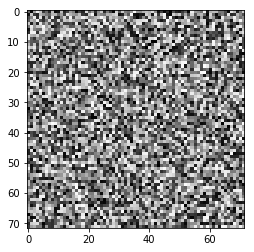

In [44]:
plt.imshow(class1_sgd.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap = 'gray')
plt.show()

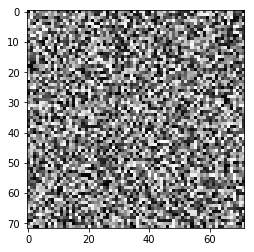

In [45]:
plt.imshow(class2_sgd.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap = 'gray')
plt.show()

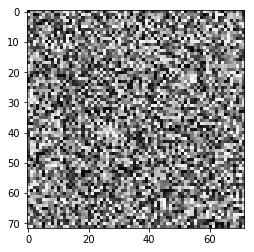

In [46]:
plt.imshow(class3_sgd.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap = 'gray')
plt.show()

Train on 225 samples, validate on 75 samples
Epoch 1/20
225/225 [==============================] - 1s 4ms/step - loss: 0.2017 - acc: 0.4711 - val_loss: 0.3269 - val_acc: 0.2267
Epoch 2/20
225/225 [==============================] - 0s 980us/step - loss: 0.1737 - acc: 0.6267 - val_loss: 0.2569 - val_acc: 0.4267
Epoch 3/20
225/225 [==============================] - 0s 975us/step - loss: 0.1521 - acc: 0.6800 - val_loss: 0.2137 - val_acc: 0.4400
Epoch 4/20
225/225 [==============================] - 0s 940us/step - loss: 0.1492 - acc: 0.6889 - val_loss: 0.2179 - val_acc: 0.4000
Epoch 5/20
225/225 [==============================] - 0s 966us/step - loss: 0.1453 - acc: 0.6978 - val_loss: 0.1872 - val_acc: 0.5333
Epoch 6/20
225/225 [==============================] - 0s 962us/step - loss: 0.1330 - acc: 0.7111 - val_loss: 0.3803 - val_acc: 0.2267
Epoch 7/20
225/225 [==============================] - 0s 984us/step - loss: 0.1329 - acc: 0.7111 - val_loss: 0.2826 - val_acc: 0.4000
Epoch 8/20
225/225 

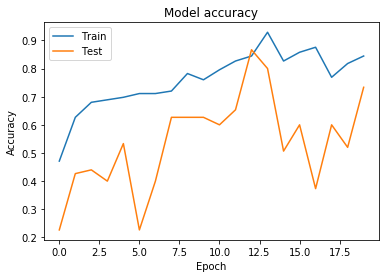

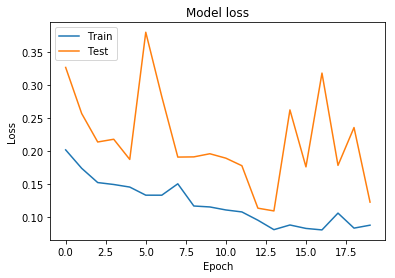

In [41]:
# We will now plot the accuracy and loss function values for the neural network models for different epochs 
model_sgd = Sequential()
model_sgd.add(Dense(neurons, activation='relu'))
model_sgd.add(Dense(neurons, activation='relu'))
model_sgd.add(Dense(neurons, activation='relu'))
model_sgd.add(Dense(3, activation='softmax'))

sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)

model_sgd.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['acc'])

history = model_sgd.fit(X_train, Y_train, validation_split=0.25, epochs=20, batch_size=16, verbose=1)

# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

Now let us visualize the 3 columns of the predicted values of the Adam Optimizer model

In [31]:
model_adm.get_weights()

[array([[-0.00316599, -0.03147669, -0.03680748, ...,  0.00699421,
          0.01352433, -0.02867492],
        [-0.02609783,  0.00882567,  0.02690132, ...,  0.00354995,
         -0.03090111, -0.00725807],
        [-0.03237803, -0.03263774, -0.0142345 , ..., -0.03309394,
         -0.00885271,  0.0005224 ],
        ...,
        [ 0.0137181 , -0.03448808, -0.01432441, ..., -0.03537082,
         -0.01723068,  0.01660337],
        [-0.02719125,  0.0045346 ,  0.02451446, ..., -0.02501553,
         -0.02540212, -0.03079867],
        [-0.02114446, -0.03395757, -0.02203007, ...,  0.00322467,
          0.017471  , -0.00784349]], dtype=float32),
 array([ 0.        , -0.00549891, -0.00568477, -0.00570181, -0.00292582,
        -0.0056504 ,  0.        ,  0.00326009, -0.00570365, -0.00244545,
        -0.00323512, -0.0057192 , -0.00570964, -0.00571852, -0.00549758,
         0.        , -0.00786344, -0.00570332,  0.        , -0.00571655,
        -0.00074079, -0.00332478, -0.00020263, -0.00476839, -0.003

In [32]:
weights = model_adm.get_weights()[0]

class1 = weights[:,0]
class2 = weights[:,1]
class3 = weights[:,2]

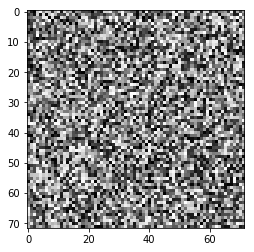

In [33]:
plt.imshow(class1.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap = 'gray')
plt.show()

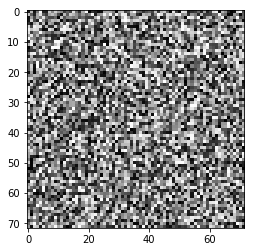

In [34]:
plt.imshow(class2.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap = 'gray')
plt.show()

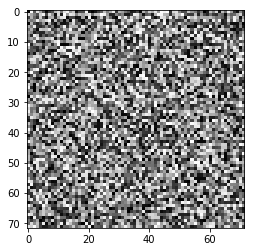

In [35]:
plt.imshow(class3.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap = 'gray')
plt.show()

## 5. A more difficult Classification Problem

Now we will work on developing a more complicated model with better performance with multiple depth of different layers

In [47]:
# Now, the shapes are allowed to move within the images and change dimensions, hence we give the parameter free_location as true
[X_train, Y_train] = generate_dataset_classification(300, 20, True)

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


In [48]:
# Generating a random test sample images
[X_test, Y_test] = generate_test_set_classification()

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


In [49]:
Y_train = np_utils.to_categorical(Y_train, 3)

In [50]:
Y_train.shape

(300, 3)

In [51]:
# Using the same set of features which we used to build our previous deep learning model: 

model = Sequential()
model.add(Dense(64, activation='relu'))
model.add(Dense(64, activation = 'relu'))
model.add(Dense(64, activation = 'relu'))
model.add(Dense(3, activation = 'softmax'))

adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

In [52]:
model.fit(X_train, Y_train, epochs=20)

Epoch 1/20
300/300 [==============================] - 1s 3ms/step - loss: 0.2691 - acc: 0.3233
Epoch 2/20
300/300 [==============================] - 0s 568us/step - loss: 0.2643 - acc: 0.3767
Epoch 3/20
300/300 [==============================] - 0s 535us/step - loss: 0.2719 - acc: 0.4067
Epoch 4/20
300/300 [==============================] - 0s 565us/step - loss: 0.2652 - acc: 0.4000
Epoch 5/20
300/300 [==============================] - 0s 583us/step - loss: 0.2479 - acc: 0.5233
Epoch 6/20
300/300 [==============================] - 0s 562us/step - loss: 0.2442 - acc: 0.5000
Epoch 7/20
300/300 [==============================] - 0s 565us/step - loss: 0.2271 - acc: 0.5267
Epoch 8/20
300/300 [==============================] - 0s 664us/step - loss: 0.2029 - acc: 0.4933
Epoch 9/20
300/300 [==============================] - 0s 505us/step - loss: 0.1911 - acc: 0.5067
Epoch 10/20
300/300 [==============================] - 0s 538us/step - loss: 0.1730 - acc: 0.5800
Epoch 11/20
300/300 [==========

In [53]:
# Using the model.evaluate feature, we can assess the overall accuracy and loss of the model
model.evaluate(X_test, Y_test) 

300/300 [==============================] - 0s 715us/step


[0.17055600146452585, 0.5833333333333334]

##### We are asked to build a deeper convoluted neural network with pooling layers and fully connected layers. In order for the vector to be fed into the model, we will have to reshape it to the desired format as follows

In [54]:
X_train_rs = X_train.reshape(X_train.shape[0], IMAGE_SIZE, IMAGE_SIZE, 1)
X_test_rs = X_test.reshape(X_test.shape[0], IMAGE_SIZE, IMAGE_SIZE, 1)

In [58]:
# Create the neural network model with CNN, Pooling and Fully connected layers
model_cnn = Sequential()
#add model layers
# Add the Convolutional Neural Network for 2D
model_cnn.add(Conv2D(16, kernel_size=5, activation='relu'))

#Add a pooling layer in between model
model_cnn.add(MaxPooling2D(pool_size=(5, 5), strides=None, padding='valid', data_format=None))

#Add the fully connected local layer in our neural network model
model_cnn.add(LocallyConnected2D(16, kernel_size=5, strides=(1, 1), padding='valid', data_format=None, activation='softmax', use_bias=True, kernel_initializer='glorot_uniform', bias_initializer='zeros'))

#Flatten the model in order to connect the convolutional layers to the Dense Core layer
model_cnn.add(Flatten())

# Add the final Dense core layer to finish the model
model_cnn.add(Dense(3, activation='softmax'))


#compile model using accuracy to measure model performance
model_cnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

In [59]:
model_cnn.fit(X_train_rs, Y_train, epochs=20)

Epoch 1/20
300/300 [==============================] - 3s 12ms/step - loss: 0.2208 - acc: 0.3800
Epoch 2/20
300/300 [==============================] - 2s 6ms/step - loss: 0.2213 - acc: 0.4433
Epoch 3/20
300/300 [==============================] - 2s 6ms/step - loss: 0.2146 - acc: 0.4867
Epoch 4/20
300/300 [==============================] - 2s 6ms/step - loss: 0.2067 - acc: 0.5700
Epoch 5/20
300/300 [==============================] - 2s 6ms/step - loss: 0.2022 - acc: 0.4967
Epoch 6/20
300/300 [==============================] - 2s 6ms/step - loss: 0.1933 - acc: 0.5800
Epoch 7/20
300/300 [==============================] - 2s 6ms/step - loss: 0.1842 - acc: 0.6833
Epoch 8/20
300/300 [==============================] - 2s 6ms/step - loss: 0.1742 - acc: 0.6700
Epoch 9/20
300/300 [==============================] - 2s 6ms/step - loss: 0.1667 - acc: 0.6833
Epoch 10/20
300/300 [==============================] - 2s 6ms/step - loss: 0.1546 - acc: 0.7567
Epoch 11/20
300/300 [===========================

In [60]:
# Using the model.evaluate feature, we can assess the overall accuracy and loss of the model
model_cnn.evaluate(X_train_rs, Y_train)

300/300 [==============================] - 1s 4ms/step


[0.07426313479741414, 0.89]

In [61]:
# Check the model summary to obtain overall insights of our deep learning model
model_cnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 68, 68, 16)        416       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 13, 13, 16)        0         
_________________________________________________________________
locally_connected2d_2 (Local (None, 9, 9, 16)          519696    
_________________________________________________________________
flatten_2 (Flatten)          (None, 1296)              0         
_________________________________________________________________
dense_38 (Dense)             (None, 3)                 3891      
Total params: 524,003
Trainable params: 524,003
Non-trainable params: 0
_________________________________________________________________


## 6. A Regression Problem

The task now is to predict the image locations of the vertices of a triangle, given an image of this triangle.

In [64]:
# generate the required regression dataset
[X_train, Y_train] = generate_dataset_regression(300, 20)

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


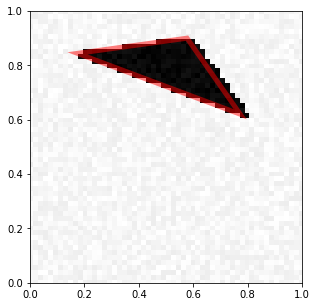

In [65]:
# plot a training sample using the visualize prediction function
visualize_prediction(X_train[0], Y_train[0]) 

In [66]:
[X_test, Y_test] = generate_test_set_regression()

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


In [67]:
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [69]:
Y_train.shape

(300, 6)

In [70]:
# define base model with core layers
def baseline_model():
    # create model
    model = Sequential()
    model.add(Dense(neurons, kernel_initializer='normal', activation='relu'))
    model.add(Dense(6, kernel_initializer='normal'))
    # Compile model
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

In [71]:
# evaluate model with standardized dataset using Keras Regressor
estimator = KerasRegressor(build_fn=baseline_model, epochs=100, batch_size=5, verbose=0)

In [74]:
kfold = KFold(n_splits=10)
results = cross_val_score(estimator, X_train, Y_train, cv=kfold)
print("Results: %.2f (%.2f) MSE" % (results.mean(), results.std()))

Results: -0.08 (0.01) MSE


In [76]:
# evaluate model with standardized dataset
estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('mlp', KerasRegressor(build_fn=baseline_model, epochs=50, batch_size=5, verbose=0)))
pipeline = Pipeline(estimators)
kfold = KFold(n_splits=10)
results = cross_val_score(pipeline, X_train, Y_train, cv=kfold)
print("Standardized: %.2f (%.2f) MSE" % (results.mean(), results.std()))

Standardized: -0.19 (0.04) MSE


In [78]:
estimator.fit(X_train, Y_train)

In [84]:
# Predict the values of y for the test data
y_pred = estimator.predict(X_test)
y_pred

array([[0.57618225, 0.48132205, 0.5650029 , 0.5144368 , 0.5870234 ,
        0.47254327],
       [0.41394702, 0.5856964 , 0.39995983, 0.5372573 , 0.38215908,
        0.60295534],
       [0.34230566, 0.58747923, 0.32520556, 0.5153069 , 0.2917602 ,
        0.61414284],
       ...,
       [0.30333537, 0.50600964, 0.28105727, 0.44377562, 0.24271126,
        0.5338941 ],
       [0.23580597, 0.36483553, 0.20455521, 0.31982315, 0.15771712,
        0.39483565],
       [0.4459414 , 0.5233189 , 0.43074128, 0.50254637, 0.42262354,
        0.53346837]], dtype=float32)

In [85]:
# summary of values of the X, Predicted and Actuals
for i in range(3):
    print("X=%s, Predicted=%s, Actual=%s" % (X_test[i], y_pred[i], Y_test[i]))

X=[0.97971582 0.98408924 0.9952138  ... 0.96632057 0.96371418 0.99983144], Predicted=[0.57618225 0.48132205 0.5650029  0.5144368  0.5870234  0.47254327], Actual=[0.94133439 0.93818117 0.67661723 0.27556678 0.36340393 0.33217252]
X=[0.980205   0.9494385  0.99064977 ... 0.98630824 0.94669241 0.95031914], Predicted=[0.41394702 0.5856964  0.39995983 0.5372573  0.38215908 0.60295534], Actual=[0.49350036 0.81401674 0.17839825 0.77686033 0.51306942 0.78858177]
X=[0.97088494 0.99175157 0.94548286 ... 0.95201227 0.98255148 0.96649708], Predicted=[0.34230566 0.58747923 0.32520556 0.5153069  0.2917602  0.61414284], Actual=[0.23325432 0.15415605 0.5149824  0.45317341 0.32182751 0.87390724]


## 7. Image Denoising

In [27]:
import keras.backend as K
from keras.initializers import VarianceScaling
from keras.engine.topology import Layer, InputSpec

from scipy.misc import imread
from sklearn.metrics import accuracy_score, normalized_mutual_info_score
from keras.layers import Dense, Input, Conv2D, MaxPool2D, UpSampling2D
from keras.models import Model
from keras import callbacks

In [10]:
train_x = generate_a_disk()

In [13]:
train_x_aug = generate_a_disk(0.2)

In [14]:
val_x =  generate_a_disk()

In [15]:
val_x_aug = generate_a_disk(0.2)

In [16]:
train_x = train_x/255.
val_x = val_x/255.

train_x = train_x.reshape(-1, IMAGE_SIZE, IMAGE_SIZE, 1)
val_x = val_x.reshape(-1, IMAGE_SIZE, IMAGE_SIZE, 1)

train_x_aug = train_x_aug/255.
val_x_aug = val_x_aug/255.

train_x_aug = train_x_aug.reshape(-1, IMAGE_SIZE, IMAGE_SIZE, 1)
val_x_aug = val_x_aug.reshape(-1, IMAGE_SIZE, IMAGE_SIZE, 1)

In [21]:
# this is our input placeholder
input_img = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 1))

# "encoded" is the encoded representation of the input
encoded = Conv2D(64, (3, 3), activation='relu', padding='same')(input_img)
encoded = MaxPool2D((2, 2), padding='same')(encoded)
encoded = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
encoded = MaxPool2D((2, 2), padding='same')(encoded)
encoded = Conv2D(16, (3, 3), activation='relu', padding='same')(encoded)
encoded = MaxPool2D((2, 2), padding='same')(encoded)

# "decoded" is the lossy reconstruction of the input
decoded = Conv2D(16, (3, 3), activation='relu', padding='same')(encoded)
decoded = UpSampling2D((2, 2))(decoded)
decoded = Conv2D(32, (3, 3), activation='relu', padding='same')(decoded)
decoded = UpSampling2D((2, 2))(decoded)
decoded = Conv2D(64, (3, 3), activation='relu')(decoded)
decoded = UpSampling2D((2, 2))(decoded)
decoded = Conv2D(1, (3, 3), padding='same')(decoded)

# this model maps an input to its reconstruction
autoencoder = Model(input_img, decoded)

In [22]:
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 72, 72, 1)         0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 72, 72, 64)        640       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 36, 36, 32)        18464     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 18, 18, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 18, 18, 16)        4624      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 9, 9, 16)          0         
__________

In [23]:
encoder = Model(input_img, encoded)

In [24]:
autoencoder.compile(optimizer='adam', loss='mse')

In [30]:
estop = callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='auto')

In [ ]:
train_history = autoencoder.fit(train_x_aug, train_x, epochs=20, batch_size=32, validation_data=(val_x_aug, val_x), callbacks=[estop])